In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob

In [2]:
ds = xr.open_dataset('/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-01-01-00000.nc')
ds

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, mlat: 97, mlon: 80, lev: 126, ilev: 127,
                   time: 24, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * mlat          (mlat) float64 -90.0 -88.12 -86.24 -84.33 ... 86.24 88.12 90.0
  * mlon          (mlon) float64 -180.0 -175.5 -171.0 ... 166.5 171.0 175.5
  * lev           (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 970.6 992.6
  * ilev          (ilev) float64 3.551e-10 4.559e-10 5.854e-10 ... 985.1 1e+03
  * time          (time) object 2100-01-01 00:00:00 ... 2100-01-01 23:00:00
Dimensions without coordinates: nbnd
Data variables: (12/113)
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    ...            ...
    UI            (time, lev, lat, lon) float32 ...
    V             (time, lev, lat, lon) float32 ...
    VI            (time, lev, lat, lon) float32 ...
    WI            (time, lev, lat, lon) float32 ...
    Z3            (time, lev, lat, lon) float32 ...
    e             (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FX2100f19f19mg16NaFeMgiontransport
    logname:           earfw
    host:              d8s5b4.arc4.leed
    initial_file:      /resstore/b0154/Data/earfw/MCHEM24/Joe_WACCMX_2_WF_lev...
    topography_file:   /nobackup/earfw/cesm2_inputdata//atm/cam/topo/USGS-gto...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1

In [ ]:
def plot_monthly_avg(files_path, target_month, level_idx):
    """
    Plot the average temperature for a specified month at a given vertical level.

    Parameters:
    - files_path: Directory containing daily NetCDF files.
    - target_month: Month as a string in "YYYY-MM" format (e.g., "2100-01").
    - level_idx: Index of the vertical level to plot.
    """
    # Select files for the specified month
    file_list = sorted(
        [os.path.join(files_path, f) for f in os.listdir(files_path) 
         if f.endswith('.nc') and f"{target_month}-" in f and f'.h2.' in f]
    )

    if not file_list:
        print(f"No files found for the month {target_month}.")
        return

    # Load datasets and extract the temperature variable
    temp_datasets = []
    for file in file_list:
        ds = xr.open_dataset(file)
        if 'Fe' in ds:
            # print(ds.T)
            temp_datasets.append(ds.T)

    # Concatenate datasets along the time dimension and compute the monthly average
    combined_temp = xr.concat(temp_datasets, dim='time')
    temp_month_avg = combined_temp.mean(dim='time').isel(lev=level_idx)

    # Plot the temperature map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.Robinson())

    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Create temperature plot
    mesh = ax.pcolormesh(ds.lon, ds.lat, temp_month_avg,
                         transform=ccrs.PlateCarree(),
                         cmap='RdBu_r',
                         vmin=float(temp_month_avg.min()),
                         vmax=float(temp_month_avg.max()))

    # Add colorbar
    plt.colorbar(mesh, ax=ax, label='Concentration (mol)')

    z3_var = ds.variables['Z3']

    time_idx = 1
    
    h_geopotential = z3_var[time_idx, level_idx, :, :]

    R_e=6371000.0
    
    z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
    
    mean_altitude_m = np.mean(z_geometric)
    mean_altitude_km = mean_altitude_m / 1000.0
    
    
    # Set title
    plt.title(f'Monthly Average Fe at height {mean_altitude_km:.2f} km for {target_month}')
    return temp_month_avg, mean_altitude_km

In [ ]:
lev_idx = 52
path_to_daily_files_2100 = f"/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/"
temp_month_avg_2100, alt = plot_monthly_avg(path_to_daily_files_2100, target_month='2100-01', level_idx=lev_idx)
path_to_daily_files_2000 = f"/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/"
temp_month_avg_2000, alt = plot_monthly_avg(path_to_daily_files_2000, target_month='0001-01', level_idx=lev_idx)
temp_month_diff = temp_month_avg_2100 - temp_month_avg_2000
# temp_month_diff.lev.values

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.Robinson())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

vmin = temp_month_diff.min()  
vmax = temp_month_diff.max()
levels = np.linspace(vmin, vmax, 20)

mesh = ax.contourf(temp_month_diff.lon, temp_month_diff.lat, temp_month_diff,
                     transform=ccrs.PlateCarree(),
                     levels=levels,
                     cmap='RdBu_r',
                     extend='both')

plt.colorbar(mesh, ax=ax, label='Fe concentration (mol)')

plt.title(f'Monthly Average Fe at height {alt:.2f} km for Jan')
plt.show()

In [ ]:
def plot_height_profile(base_path):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    monthly_temps = []
    monthly_heights = []

    for month in [f"{i:02d}" for i in range(1, 13)]:
        file_pattern = base_path.format(month=month, day='*')
        files = glob.glob(file_pattern)
        
        ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
        
        # Calculate spatial and temporal mean temperature at each level
        temp_profile = ds.Fe.mean(dim=['time', 'lat', 'lon'])
        monthly_temps.append(temp_profile.values)
        
        # Calculate geometric height for each level
        z3_var = ds.variables['Z3']
        h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon'])  # Spatial mean
        
        # Convert geopotential height to geometric height
        R_e = 6371000.0  # Earth's radius in meters
        z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
        monthly_heights.append(z_geometric.values / 1000.0)  # Convert to km
        
        ds.close()
    
    # Convert to numpy array and calculate annual means
    monthly_temps = np.array(monthly_temps)
    monthly_heights = np.array(monthly_heights)
    annual_mean_temp = np.mean(monthly_temps, axis=0)
    annual_mean_height = np.mean(monthly_heights, axis=0)
    
    # Create the plot
    ax.plot(annual_mean_temp, annual_mean_height, 'b-', linewidth=2, label='Annual Mean')
    
    
    # Customize the plot
    ax.grid(True)
    ax.set_xlabel('Concentration (mol)')
    ax.set_ylabel('Height (km)')
    ax.set_title('Mean Conectration Profiles - 2100')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    return fig

In [ ]:
base_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
plot_height_profile(base_path)

In [2]:
def plot_height_profile_ions(base_path):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Dictionary to store monthly values for each element
    monthly_data = {
        'Fep': [],
        'Mgp': [],
        'Nap': [],
        'e': []
    }
    monthly_heights = []
    
    for month in [f"{i:02d}" for i in range(1, 13)]:
        file_pattern = base_path.format(month=month, day='*')
        files = glob.glob(file_pattern)
        
        ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
        
        # Calculate spatial and temporal mean for each element
        for element in monthly_data.keys():
            element_profile = ds[element].mean(dim=['time', 'lat', 'lon'])
            monthly_data[element].append(element_profile.values)
        
        # Calculate geometric height for each level
        z3_var = ds.variables['Z3']
        h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon'])  # Spatial mean
        
        # Convert geopotential height to geometric height
        R_e = 6371000.0  # Earth's radius in meters
        z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
        monthly_heights.append(z_geometric.values / 1000.0)  # Convert to km
        
        ds.close()
    
    # Convert to numpy array and calculate annual means
    for element in monthly_data.keys():
        monthly_data[element] = np.array(monthly_data[element])
    
    monthly_heights = np.array(monthly_heights)
    annual_mean_height = np.mean(monthly_heights, axis=0)
    
    # Create the plot with different colors for each element
    colors = {'Fep': 'r', 'Mgp': 'g', 'Nap': 'b', 'e': 'y'}
    
    for element, color in colors.items():
        annual_mean = np.mean(monthly_data[element], axis=0)
        ax.plot(annual_mean, annual_mean_height, f'{color}-', linewidth=2, label=f'{element}')
    
    # Customize the plot
    ax.grid(True)
    ax.set_xlabel('Concentration (mol)')
    ax.set_ylabel('Height (km)')
    ax.set_title('Mean Concentration Profiles - 2100')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    return fig

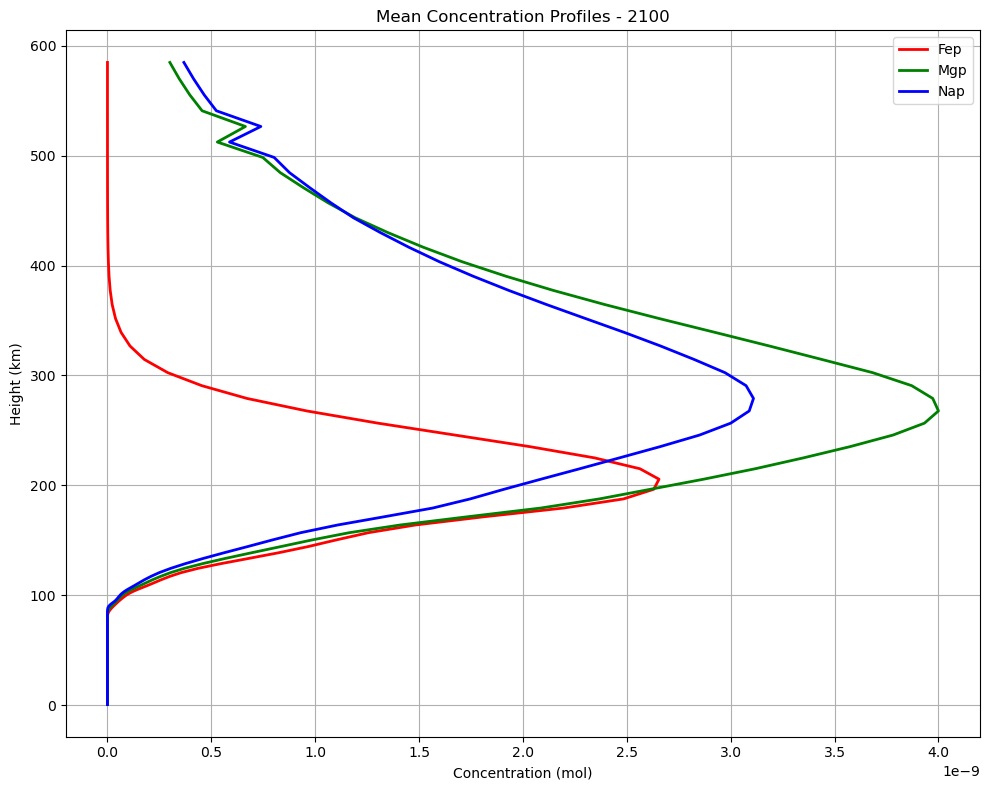

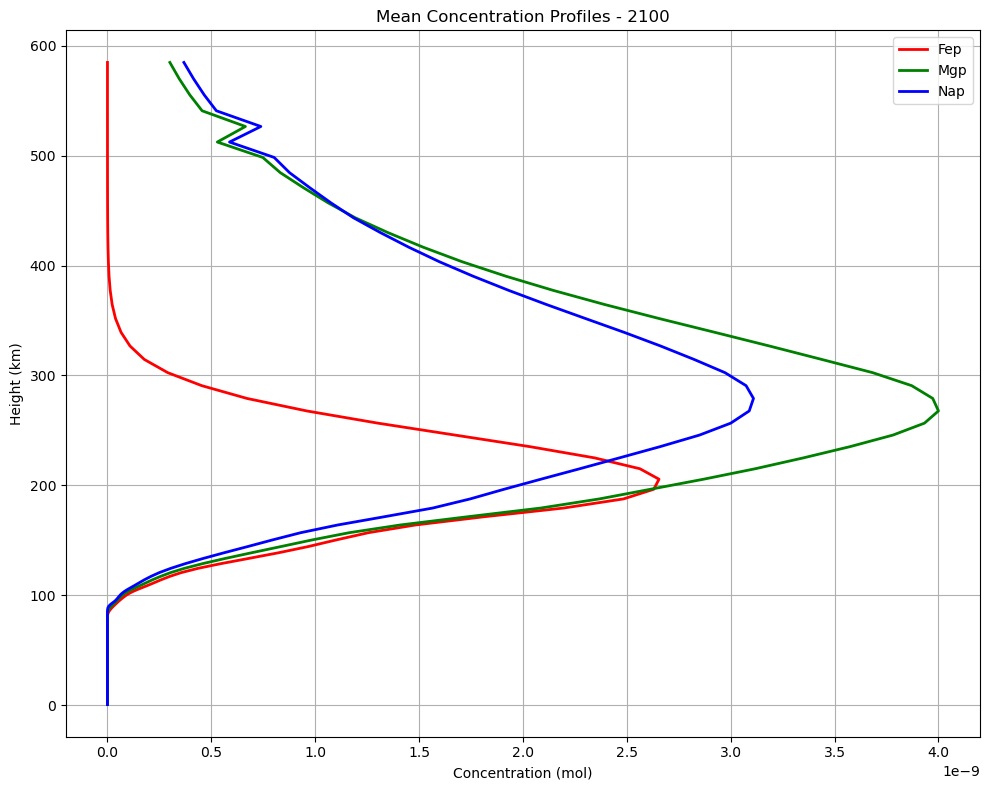

In [3]:
base_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
plot_height_profile_ions(base_path)

In [4]:
def plot_height_profile(base_path):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Dictionary to store monthly values for each element
    monthly_data = {
        'Fe': [],
        'Mg': [],
        'Na': []
    }
    monthly_heights = []
    
    for month in [f"{i:02d}" for i in range(1, 13)]:
        file_pattern = base_path.format(month=month, day='*')
        files = glob.glob(file_pattern)
        
        ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
        
        # Calculate spatial and temporal mean for each element
        for element in monthly_data.keys():
            element_profile = ds[element].mean(dim=['time', 'lat', 'lon'])
            monthly_data[element].append(element_profile.values)
        
        # Calculate geometric height for each level
        z3_var = ds.variables['Z3']
        h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon'])  # Spatial mean
        
        # Convert geopotential height to geometric height
        R_e = 6371000.0  # Earth's radius in meters
        z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
        monthly_heights.append(z_geometric.values / 1000.0)  # Convert to km
        
        ds.close()
    
    # Convert to numpy array and calculate annual means
    for element in monthly_data.keys():
        monthly_data[element] = np.array(monthly_data[element])
    
    monthly_heights = np.array(monthly_heights)
    annual_mean_height = np.mean(monthly_heights, axis=0)
    
    # Create the plot with different colors for each element
    colors = {'Fe': 'r', 'Mg': 'g', 'Na': 'b'}
    
    for element, color in colors.items():
        annual_mean = np.mean(monthly_data[element], axis=0)
        ax.plot(annual_mean, annual_mean_height, f'{color}-', linewidth=2, label=f'{element}')
    
    # Customize the plot
    ax.grid(True)
    ax.set_xlabel('Concentration (mol)')
    ax.set_ylabel('Height (km)')
    ax.set_title('Mean Concentration Profiles - 2100')
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    return fig

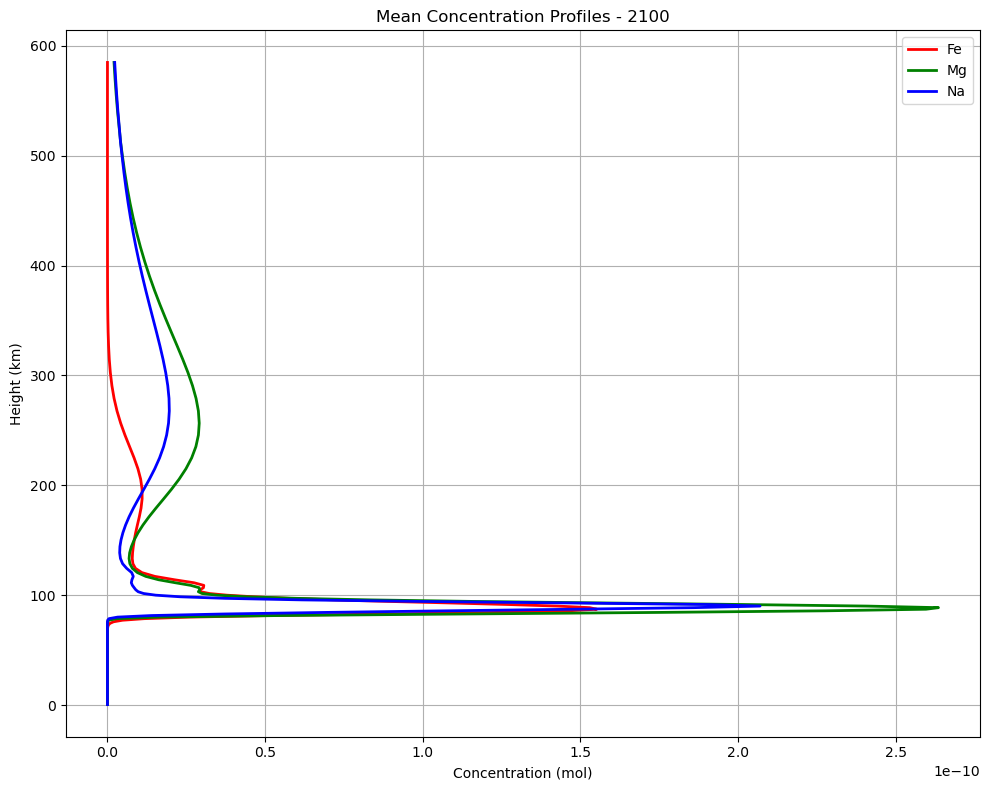

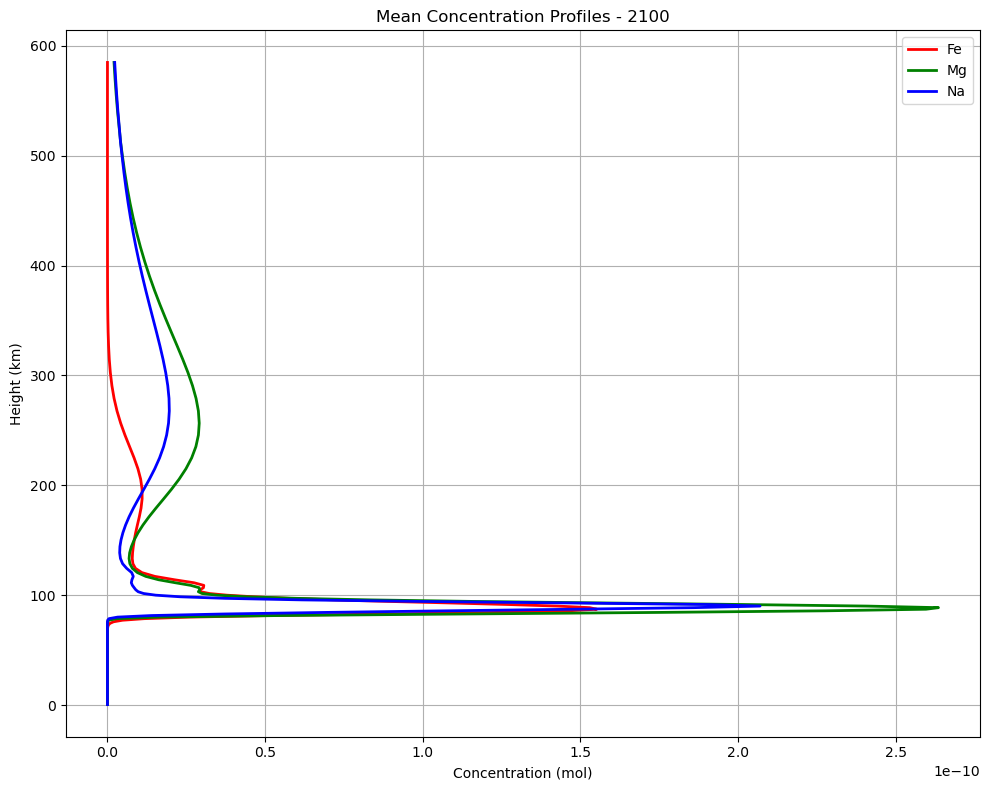

In [6]:
base_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
plot_height_profile(base_path)

In [3]:
def plot_height_profile_ions(base_path_climate, base_path_smax):
    fig = plt.figure(figsize=(15, 10))
    
    # Create two subplots: one for individual plots and one for differences
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # Dictionary to store data for each scenario
    data = {
        'climate': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': [], 'e':[]},
        'smax': {'Fep': [], 'Mgp': [], 'Nap': [], 'heights': [], 'e':[]}
    }
    
    # Process data for both scenarios
    for scenario, base_path in [('climate', base_path_climate), ('smax', base_path_smax)]:
        for month in [f"{i:02d}" for i in range(1, 13)]:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
            
            # Calculate spatial and temporal mean for each element
            for element in ['Fep', 'Mgp', 'Nap','e']:
                element_profile = ds[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)
            
            # Calculate geometric height for each level
            z3_var = ds.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon'])  # Spatial mean
            
            # Convert geopotential height to geometric height
            R_e = 6371000.0  # Earth's radius in meters
            z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
            data[scenario]['heights'].append(z_geometric.values / 1000.0)  # Convert to km
            
            ds.close()
    
    # Convert to numpy arrays and calculate annual means
    for scenario in data:
        for element in ['Fep', 'Mgp', 'Nap', 'e']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    # Define colors and line styles
    colors = {'Fep': 'r', 'Mgp': 'g', 'Nap': 'b', 'e': 'y'}
    line_styles = {'climate': '-', 'smax': '--'}
    
    # Plot data for both scenarios in the first subplot
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            annual_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                annual_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    # Plot differences in the second subplot
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smax_mean = np.mean(data['smax'][element], axis=0)
        
        # Calculate difference (assuming heights align - if not, interpolation would be needed)
        difference = climate_mean - smax_mean
        
        # Use average of both height profiles for plotting differences
        mean_height = (data['climate']['mean_height'] + data['smax']['mean_height']) / 2
        
        ax2.plot(
            difference, 
            mean_height, 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - Smax)'
        )
    
    # Customize the plots
    for ax, title in [(ax1, 'Mean Concentration Profiles'), (ax2, 'Concentration Differences (Climate - Smax)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Height (km)')
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    return fig

In [ ]:
climate_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smax_path = "/resstore/b0243/Data/Sporadic_E/Solar_Max/archive_yr2000/atm/hist/SMax_3M_FX2000_f19f19mg16.cam.h1.0001-{month}-{day}-*.nc"
plot_height_profile_ions(climate_path, Smax_path)

In [ ]:
def plot_height_profile(base_path_climate, base_path_smax):
    fig = plt.figure(figsize=(15, 10))
    
    # Create two subplots: one for individual plots and one for differences
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # Dictionary to store data for each scenario
    data = {
        'climate': {'Fe': [], 'Mg': [], 'Na': [], 'heights': []},
        'smax': {'Fe': [], 'Mg': [], 'Na': [], 'heights': []}
    }
    
    # Process data for both scenarios
    for scenario, base_path in [('climate', base_path_climate), ('smax', base_path_smax)]:
        for month in [f"{i:02d}" for i in range(1, 13)]:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
            
            # Calculate spatial and temporal mean for each element
            for element in ['Fe', 'Mg', 'Na']:
                element_profile = ds[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)
            
            # Calculate geometric height for each level
            z3_var = ds.variables['Z3']
            h_geopotential = z3_var[0, :, :, :].mean(dim=['lat', 'lon'])  # Spatial mean
            
            # Convert geopotential height to geometric height
            R_e = 6371000.0  # Earth's radius in meters
            z_geometric = (R_e * h_geopotential) / (R_e - h_geopotential)
            data[scenario]['heights'].append(z_geometric.values / 1000.0)  # Convert to km
            
            ds.close()
    
    # Convert to numpy arrays and calculate annual means
    for scenario in data:
        for element in ['Fe', 'Mg', 'Na']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    # Define colors and line styles
    colors = {'Fe': 'r', 'Mg': 'g', 'Na': 'b'}
    line_styles = {'climate': '-', 'smax': '--'}
    
    # Plot data for both scenarios in the first subplot
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            annual_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                annual_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    # Plot differences in the second subplot
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smax_mean = np.mean(data['smax'][element], axis=0)
        
        # Calculate difference (assuming heights align - if not, interpolation would be needed)
        difference = climate_mean - smax_mean
        
        # Use average of both height profiles for plotting differences
        mean_height = (data['climate']['mean_height'] + data['smax']['mean_height']) / 2
        
        ax2.plot(
            difference, 
            mean_height, 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - Smax)'
        )
    
    # Customize the plots
    for ax, title in [(ax1, 'Mean Concentration Profiles'), (ax2, 'Concentration Differences (Climate - Smax)')]:
        ax.grid(True)
        ax.set_xlabel('Concentration (mol/mol)')
        ax.set_ylabel('Height (km)')
        ax.set_title(title)
        ax.legend()
    
    plt.tight_layout()
    return fig

In [ ]:
climate_path = "/resstore/b0243/Data/earfw/FX2100f19f19mg16NaFeMgiontransport/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smax_path = "/resstore/b0243/Data/Sporadic_E/Solar_Max/archive_yr2000/atm/hist/SMax_3M_FX2000_f19f19mg16.cam.h1.0001-{month}-{day}-*.nc"
plot_height_profile(climate_path, Smax_path)